In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import gc
from time import time
import datetime
from tqdm import tqdm_notebook
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold,KFold
from sklearn.metrics import precision_score, recall_score, confusion_matrix, accuracy_score, roc_auc_score, f1_score, roc_curve, auc,precision_recall_curve
from sklearn.metrics import classification_report
import itertools
from scipy import interp
import math
import random
import datetime
from sklearn.impute import SimpleImputer


warnings.simplefilter('ignore')
sns.set()
%matplotlib inline

In [2]:
%%time
# 加载数据集  已初步剔除了一些无效特征
folder_path = './input/'
train = pd.read_csv(f'{folder_path}train.csv')
test_all = pd.read_csv(f'{folder_path}test.csv') # 包含标签hospital_death
y_test = test_all['hospital_death']
test = test_all.drop(['hospital_death'],axis=1)
print("train shape:",train.shape)
print("test_all shape",test_all.shape)
print("test shape",test.shape)


train shape: (73370, 74)
test_all shape (18343, 74)
test shape (18343, 73)
CPU times: user 360 ms, sys: 57 ms, total: 417 ms
Wall time: 418 ms


In [3]:
# 通过null importance 选出来的有效特征55个
uesful_features = [
 'age',
 'bmi',
 'elective_surgery',
 'gender',
 'icu_admit_source',
 'icu_id',
 'pre_icu_los_days',
 'apache_2_diagnosis',
 'apache_3j_diagnosis',
 'apache_post_operative',
 'gcs_eyes_apache',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'intubated_apache',
 'map_apache',
 'resprate_apache',
 'temp_apache',
 'ventilated_apache',
 'd1_diasbp_min',
 'd1_diasbp_noninvasive_min',
 'd1_heartrate_max',
 'd1_heartrate_min',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_mbp_noninvasive_max',
 'd1_mbp_noninvasive_min',
 'd1_resprate_max',
 'd1_resprate_min',
 'd1_spo2_max',
 'd1_spo2_min',
 'd1_sysbp_max',
 'd1_sysbp_min',
 'd1_sysbp_noninvasive_max',
 'd1_sysbp_noninvasive_min',
 'd1_temp_max',
 'd1_temp_min',
 'h1_diasbp_min',
 'h1_diasbp_noninvasive_min',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'h1_mbp_noninvasive_min',
 'h1_resprate_max',
 'h1_resprate_min',
 'h1_spo2_max',
 'h1_spo2_min',
 'h1_sysbp_max',
 'h1_sysbp_min',
 'h1_sysbp_noninvasive_min',
 'd1_glucose_min',
 'd1_potassium_max',
 'd1_potassium_min',
 'apache_4a_hospital_death_prob',
 'apache_4a_icu_death_prob',
 'diabetes_mellitus']
len(uesful_features)

55

In [4]:
cols_to_drop = [col for col in train.columns if col not in uesful_features]
cols_to_drop.remove('hospital_death')

print("清理前 train shape:", train.shape)
print("清理前 test  shape:", test.shape)
print("\n")
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)
print("清理后 train shape:", train.shape)
print("清理后 test  shape:", test.shape)

清理前 train shape: (73370, 74)
清理前 test  shape: (18343, 73)


清理后 train shape: (73370, 56)
清理后 test  shape: (18343, 55)


In [5]:
# # LabelEncoder
# for col in tqdm_notebook(train.columns):
#     if train[col].dtype == "object":
#         encoder = LabelEncoder()
#         encoder.fit(list(train[col].values) + list(test[col].values))
#         train[col] = encoder.transform(list(train[col].values))
#         test[col] = encoder.transform(list(test[col].values))
        
# train = train.reset_index() # 重置索引
# test = test.reset_index()

In [6]:
# one_hot
catColnums = train.select_dtypes(include=['object']).columns
train = pd.get_dummies(train, columns= catColnums)
test = pd.get_dummies(test, columns= catColnums)

In [7]:
# from sklearn.preprocessing import StandardScaler
# # 填充缺失值
# imp = SimpleImputer(strategy='median')
# new_train = pd.DataFrame(imp.fit_transform(train),columns=train.columns)
# new_test = pd.DataFrame(imp.fit_transform(test),columns=test.columns)

# train_df = new_train.copy()
# test_df = new_test.copy()
# # 进行归一化
# train_df = pd.DataFrame(StandardScaler().fit_transform(train_df),columns=train_df.columns)
# train_df['hospital_death'] = new_train['hospital_death']
# test_df = pd.DataFrame(StandardScaler().fit_transform(test_df),columns=test_df.columns)


In [8]:
# X = train_df.drop(['hospital_death'],axis=1)
# y = train_df['hospital_death']
# X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 1234)

In [7]:
X = train.drop(['hospital_death'],axis=1)
y = train['hospital_death']
X_train, X_val, y_train, y_val = train_test_split(X, y,stratify=y, test_size = 0.2, random_state = 1234)

In [10]:
res = []
plot_f = [] 

In [11]:
# 适应度 ROC_AUC score
def f(param_arr,X_train, X_val, y_train, y_val):
    params = {
                
        "num_leaves" : int(param_arr[0]),        # [31,500] int  
        "min_data_in_leaf" : int(param_arr[1]) , # [20,200] int 注意调整 
        "bagging_fraction" : param_arr[2],       # [0.1,0.9] float 调整
        "feature_fraction" : param_arr[3],       # [0.1,0.9] float
        "learning_rate" : param_arr[4],          # [0.01,0.3] float 
        "min_child_weight":param_arr[5],         #[0.00001, 0.01] float
        "reg_alpha" : param_arr[6] ,             # [0,1] float
        "reg_lambda" : param_arr[7] ,            # [0,1] float 
         "max_depth":int(param_arr[8]),           #[-1,50] int
        
        "metric": 'auc', # 衡量标准
        'verbose': -1,
        "objective" : 'binary', # 任务：二分类
#         "max_depth" : -1, # -1 ： 不限制深度
        "boosting_type" : "gbdt", # 'dart', 'goss', 'rf'
        "random_state" : 66, # 随机种子
        "n_jobs" : 7,
        'save_binary': True,
        
    }
    
    train_dataset = lgb.Dataset(X_train, label=y_train) # 训练集
    val_dataset = lgb.Dataset(X_val, label=y_val) # 验证集

    lgb_model = lgb.train(params=params, # 超参数设置
                          train_set=train_dataset, # 训练数据
                          num_boost_round=20000, # 循环的轮数
                          valid_sets=val_dataset, # 验证数据
                          valid_names='validation', # 验证集名称
                          verbose_eval = 200,
                          early_stopping_rounds=200 ) # 如果200轮后没有提升，就停止循环
 
    
    # 对验证集进行预测
    y_val_pred = lgb_model.predict(X_val)
    # 计算roc_auc
    roc_auc = roc_auc_score(y_val, y_val_pred)
    

    
    return roc_auc, lgb_model 

In [12]:
def PSO():
    N = 40                   # 种群数量 
    d = 9                    # 可行解的维数（优化参数个数） 
    ger = 15                # 种群最大迭代次数
    Fu_INF = -math.inf       # -∞
    w = 0.8                  # 惯性权重
    c1 = 0.5                 # 自我学习因子
    c2 = 0.5                 # 群体学习因子
    

    ## X_limit 是每个待优化参数的取值范围 
    #  X1_min,X1_max 是第一个参数的最小和最大值 
    #  Xn_min,Xn_max是第n个参数的最大最小值

    
    # 参数范围 [[31,500],[20,200],[0.1,0.9],[0.1,0.9],[0.01,0.3],[0.00001,0.01],[0,1],[0,1]]
    # 参数速度 [[-3,3],[-2,2],[-0.01,0.01],[-0.01,0.01],[-0.01,0.01],[-0.001,0.001],[-0.01,0.01],[-0.01,0.01]]
    
    X_limit = [[31,500],[20,200],[0.1,0.9],[0.1,0.9],[0.01,0.3],[0.00001,0.01],[0,1],[0,1],[-1,50]]
    X1_min = X_limit[0][0]
    X1_max = X_limit[0][1]
    
    X2_min = X_limit[1][0]
    X2_max = X_limit[1][1]
    
    X3_min = X_limit[2][0]
    X3_max = X_limit[2][1]
    
    X4_min = X_limit[3][0]
    X4_max = X_limit[3][1]
    
    X5_min = X_limit[4][0]
    X5_max = X_limit[4][1]
    
 
    
    X6_min = X_limit[5][0]
    X6_max = X_limit[5][1]
    
    X7_min = X_limit[6][0]
    X7_max = X_limit[6][1]
    
    X8_min = X_limit[7][0]
    X8_max = X_limit[7][1]
    
    X9_min = X_limit[8][0]
    X9_max = X_limit[8][1]
    
    ## V_limit 是每个带优化参数对应的速度
    #  V1_min,V1_max 是第一个参数对应的最小和最大速度 
    #  Vn_min,Vn_max是第n个参数对应速度的最大最小值

    V_limit = [[-3,3],[-2,2],[-0.01,0.01],[-0.01,0.01],[-0.01,0.01],[-0.001,0.001],[-0.01,0.01],[-0.01,0.01],[-2,2]]
    V1_min = V_limit[0][0]
    V1_max = V_limit[0][1]
    
    V2_min = V_limit[1][0]
    V2_max = V_limit[1][1]

    V3_min = V_limit[2][0]
    V3_max = V_limit[2][1]
    
    V4_min = V_limit[3][0]
    V4_max = V_limit[3][1]
    
    V5_min = V_limit[4][0]
    V5_max = V_limit[4][1]
    


    V6_min = V_limit[5][0]
    V6_max = V_limit[5][1]
    
    V7_min = V_limit[6][0]
    V7_max = V_limit[6][1]

    V8_min = V_limit[7][0]
    V8_max = V_limit[7][1]
    
    V9_min = V_limit[8][0]
    V9_max = V_limit[8][1]
       

    ## 分别初始化每个参数X1、X2...Xn  再合并为X

    X1 = np.random.randint(X1_min,X1_max,(N,1))  
    X2 = np.random.randint(X2_min,X2_max,(N,1))
    
    X3 = np.random.uniform(X3_min,X3_max,(N,1))
    X4 = np.random.uniform(X4_min,X4_max,(N,1))
    X5 = np.random.uniform(X5_min,X5_max,(N,1))
    
    X6 = np.random.uniform(X6_min,X6_max,(N,1))
    X7 = np.random.uniform(X7_min,X7_max,(N,1))
    
    X8 = np.random.uniform(X8_min,X8_max,(N,1))
    X9 = np.random.randint(X9_min,X9_max,(N,1))
    
    X = np.hstack((X1,X2,X3,X4,X5,X6,X7,X8,X9))
   

    
    ## 分别初始化每个参数对应的速度V1、V2...Vn 再合并成V
    V1 = np.random.randint(V1_min,V1_max,(N,1))  
    V2 = np.random.randint(V2_min,V2_max,(N,1))
    
    V3 = np.random.uniform(V3_min,V3_max,(N,1))
    V4 = np.random.uniform(V4_min,V4_max,(N,1))
    V5 = np.random.uniform(V5_min,V5_max,(N,1))
    
    V6 = np.random.uniform(V6_min,V6_max,(N,1))
    V7 = np.random.uniform(V7_min,V7_max,(N,1))
    
    V8 = np.random.uniform(V8_min,V8_max,(N,1))
    V9 = np.random.randint(V9_min,V9_max,(N,1))  
    V = np.hstack((V1,V2,V3,V4,V5,V6,V7,V8,V9)) 
    
    
    
    # 位置 就是 待优化参数的值
    Xm = X                       # N*d维矩阵  每个 个体的历史最佳位置 
    ym = np.ones((1,N))*Fu_INF   # 种群的历史最佳位置
    fxm = np.ones((N,1))*Fu_INF  # 每个 个体历史最佳适应度
    fym = Fu_INF                 # 种群历史最佳适应度   
    
    
    ## 开始迭代
    iteration = 0
    while iteration < ger:
        # 遍历粒子
        print("\033[0;32;40m--- 第%d次迭代开始-> ---\033[0m" %(iteration+1))
        
        for i in range(N):
            starttime = datetime.datetime.now()  # 开始时刻
            # print("开始训练")
            fx,lgb_model = f(X[i,:],X_train, X_val, y_train, y_val) # 计算第i个粒子的适应度(模型准确率)
            endtime = datetime.datetime.now()    # 结束时刻
#             print("结束训练")
            print("第%d个粒子   ROC_AUC：%f  时间：%d s"  %(i+1,fx,(endtime - starttime).seconds))
            
            
            if (fx > fxm[i]):              # 当前粒子i的适应度 > 之前粒子i的适应度  
                fxm[i] = fx;               # 更新个体粒子i的历史最佳适应度（更新准确率）
                Xm[i] = X[i]               # 更新个体粒子i的历史最佳位置 （更新参数）

            if (fxm.max() > fym):          # 所有粒子中适应度(准确率)最高的 > 群体中最佳适应度（准确率）
                max_idx = fxm.argmax()     # 准确率最高的粒子下标
                fym = fxm[max_idx]         # 更新群体的最佳适应度
                ym = Xm[max_idx]           # 更新群体历史最佳位置（参数）

                # 打印+记录
                y_test_pred = lgb_model.predict(test)
                AUC_test = roc_auc_score(y_test, y_test_pred)
                ACC_test = accuracy_score(y_test, y_test_pred.round())
                PRE_test = precision_score(y_test, y_test_pred.round())
                REC_test = recall_score(y_test, y_test_pred.round())
                F1_test = f1_score(y_test, y_test_pred.round())
                # 模型参数   模型的最佳迭代次数   第几次迭代  第几个粒子  验证集AUC 测试集AUC ACC PRE REC F1
                temp_res = [lgb_model.params,lgb_model.best_iteration ,iteration+1,i+1,fym[0],AUC_test,ACC_test,PRE_test,REC_test,F1_test]
                res.append(temp_res)
                print('\033[1;31m')
                print("第%d次迭代 第%d个粒子   ROC_AUC：%f" %(iteration+1,i+1,fym))
                print('\033[0m')
                    
        
        ## 更新速度V
        #print("更新V前",V)
        V = V * w + c1 * random.random()*(Xm-X) + c2 * random.random() * (np.ones((N,1))*ym-X)
        #print("更新V后",V)


        ## 处理速度V边界
        V1 = V[:,0]
        V2 = V[:,1]
        V3 = V[:,2]
        V4 = V[:,3]
        V5 = V[:,4]
        V6 = V[:,5]
        V7 = V[:,6]
        V8 = V[:,7]
        V9 = V[:,8]
           
        
        V1[V1 < V1_min] = V1_min
        V1[V1 > V1_max] = V1_max
        V2[V2 < V2_min] = V2_min
        V2[V2 > V2_max] = V2_max  
        V3[V3 < V3_min] = V3_min
        V3[V3 > V3_max] = V3_max
        V4[V4 < V4_min] = V4_min
        V4[V4 > V4_max] = V4_max 
        V5[V5 < V5_min] = V5_min
        V5[V5 > V5_max] = V5_max
        V6[V6 < V6_min] = V6_min
        V6[V6 > V6_max] = V6_max
        V7[V7 < V7_min] = V7_min
        V7[V7 > V7_max] = V7_max  
        V8[V8 < V8_min] = V8_min
        V8[V8 > V8_max] = V8_max
        
        V9[V9 < V9_min] = V9_min
        V9[V9 > V9_max] = V9_max    
        # 位置更新
        X = X + V; 
        
        ## 处理位置X边界
        X1 = X[:,0]
        X2 = X[:,1]
        X3 = X[:,2]
        X4 = X[:,3]
        X5 = X[:,4]
        X6 = X[:,5]
        X7 = X[:,6]
        X8 = X[:,7]
        X9 = X[:,8]       
        
        
        X1[X1 < X1_min] = X1_min
        X1[X1 > X1_max] = X1_max
        X2[X2 < X2_min] = X2_min
        X2[X2 > X2_max] = X2_max  
        X3[X3 < X3_min] = X3_min
        X3[X3 > X3_max] = X3_max
        X4[X4 < X4_min] = X4_min
        X4[X4 > X4_max] = X4_max 
        X5[X5 < X5_min] = X5_min
        X5[X5 > X5_max] = X5_max
        X6[X6 < X6_min] = X6_min
        X6[X6 > X6_max] = X6_max
        X7[X7 < X7_min] = X7_min
        X7[X7 > X7_max] = X7_max  
        X8[X8 < X8_min] = X8_min
        X8[X8 > X8_max] = X8_max
        
        X9[X9 < X9_min] = X9_min
        X9[X9 > X9_max] = X9_max   
       
        iteration = iteration + 1
        
        plot_f.append([iteration,fym[0]])
        
        print("第%d次迭代结束！！" %(iteration))

In [13]:
PSO()

--- 第1次迭代开始-> ---
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884268
Early stopping, best iteration is:
[43]	validation's auc: 0.89167
第1个粒子   ROC_AUC：0.891670  时间：1 s

第1次迭代 第1个粒子   ROC_AUC：0.891670

Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888809
Early stopping, best iteration is:
[77]	validation's auc: 0.891764
第2个粒子   ROC_AUC：0.891764  时间：3 s

第1次迭代 第2个粒子   ROC_AUC：0.891764

Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.882432
[400]	validation's auc: 0.883001
Early stopping, best iteration is:
[306]	validation's auc: 0.883272
第3个粒子   ROC_AUC：0.883272  时间：7 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891045
[400]	validation's auc: 0.892878
[600]	validation's auc: 0.892594
Early stopping, best iteration is:
[447]	validation's auc: 0.893058
第4个粒子   ROC_AUC：0.893058  时间：4 s

第1次迭代 第4个粒子   ROC_AUC：0.893058

Tra

Early stopping, best iteration is:
[345]	validation's auc: 0.880372
第37个粒子   ROC_AUC：0.880372  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.879104
[400]	validation's auc: 0.884401
[600]	validation's auc: 0.886727
[800]	validation's auc: 0.887981
[1000]	validation's auc: 0.889003
[1200]	validation's auc: 0.889599
[1400]	validation's auc: 0.890155
[1600]	validation's auc: 0.890614
[1800]	validation's auc: 0.890873
[2000]	validation's auc: 0.891198
[2200]	validation's auc: 0.891368
[2400]	validation's auc: 0.891546
[2600]	validation's auc: 0.891615
[2800]	validation's auc: 0.891732
[3000]	validation's auc: 0.891877
[3200]	validation's auc: 0.891947
[3400]	validation's auc: 0.892016
[3600]	validation's auc: 0.892088
[3800]	validation's auc: 0.89214
[4000]	validation's auc: 0.892202
[4200]	validation's auc: 0.892224
[4400]	validation's auc: 0.892297
[4600]	validation's auc: 0.892356
[4800]	validation's auc: 0.89238
[5000]	validation's auc: 0

第29个粒子   ROC_AUC：0.892709  时间：10 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888334
Early stopping, best iteration is:
[130]	validation's auc: 0.889671
第30个粒子   ROC_AUC：0.889671  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884162
Early stopping, best iteration is:
[42]	validation's auc: 0.885219
第31个粒子   ROC_AUC：0.885219  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893833
[400]	validation's auc: 0.892977
Early stopping, best iteration is:
[223]	validation's auc: 0.894031
第32个粒子   ROC_AUC：0.894031  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.886326
Early stopping, best iteration is:
[60]	validation's auc: 0.893167
第33个粒子   ROC_AUC：0.893167  时间：1 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891736
Early stopping, best iteration is:
[151]	validation

[200]	validation's auc: 0.888654
Early stopping, best iteration is:
[60]	validation's auc: 0.892248
第23个粒子   ROC_AUC：0.892248  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.88073
Early stopping, best iteration is:
[37]	validation's auc: 0.885941
第24个粒子   ROC_AUC：0.885941  时间：1 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.887427
Early stopping, best iteration is:
[50]	validation's auc: 0.890401
第25个粒子   ROC_AUC：0.890401  时间：1 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.882521
Early stopping, best iteration is:
[67]	validation's auc: 0.889976
第26个粒子   ROC_AUC：0.889976  时间：1 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884944
Early stopping, best iteration is:
[25]	validation's auc: 0.885829
第27个粒子   ROC_AUC：0.885829  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's au

Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.88343
Early stopping, best iteration is:
[50]	validation's auc: 0.889161
第21个粒子   ROC_AUC：0.889161  时间：1 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.894695
[400]	validation's auc: 0.89379
Early stopping, best iteration is:
[209]	validation's auc: 0.894774
第22个粒子   ROC_AUC：0.894774  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888092
Early stopping, best iteration is:
[57]	validation's auc: 0.891846
第23个粒子   ROC_AUC：0.891846  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884437
Early stopping, best iteration is:
[45]	validation's auc: 0.885491
第24个粒子   ROC_AUC：0.885491  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.8904
Early stopping, best iteration is:
[86]	validation's auc: 0.891539
第25个粒子   ROC_AUC：0.89153

Early stopping, best iteration is:
[90]	validation's auc: 0.889927
第18个粒子   ROC_AUC：0.889927  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.883985
Early stopping, best iteration is:
[24]	validation's auc: 0.885856
第19个粒子   ROC_AUC：0.885856  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.894462
[400]	validation's auc: 0.893211
Early stopping, best iteration is:
[200]	validation's auc: 0.894462
第20个粒子   ROC_AUC：0.894462  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.877224
Early stopping, best iteration is:
[50]	validation's auc: 0.886411
第21个粒子   ROC_AUC：0.886411  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893343
[400]	validation's auc: 0.894868
[600]	validation's auc: 0.894492
Early stopping, best iteration is:
[475]	validation's auc: 0.89514
第22个粒子   ROC_AUC：0.895140  时间：8 s
Training until 

[800]	validation's auc: 0.893699
Early stopping, best iteration is:
[647]	validation's auc: 0.893836
第15个粒子   ROC_AUC：0.893836  时间：20 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.885751
Early stopping, best iteration is:
[137]	validation's auc: 0.887886
第16个粒子   ROC_AUC：0.887886  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.89328
[400]	validation's auc: 0.89523
[600]	validation's auc: 0.895435
[800]	validation's auc: 0.895476
Early stopping, best iteration is:
[722]	validation's auc: 0.895655
第17个粒子   ROC_AUC：0.895655  时间：14 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889673
Early stopping, best iteration is:
[103]	validation's auc: 0.890612
第18个粒子   ROC_AUC：0.890612  时间：6 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.887497
Early stopping, best iteration is:
[38]	validation's auc: 0.889893
第19个粒子   ROC_

[400]	validation's auc: 0.890197
Early stopping, best iteration is:
[227]	validation's auc: 0.89131
第11个粒子   ROC_AUC：0.891310  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.883934
Early stopping, best iteration is:
[63]	validation's auc: 0.885181
第12个粒子   ROC_AUC：0.885181  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888839
Early stopping, best iteration is:
[51]	validation's auc: 0.89104
第13个粒子   ROC_AUC：0.891040  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893213
[400]	validation's auc: 0.894029
Early stopping, best iteration is:
[377]	validation's auc: 0.89413
第14个粒子   ROC_AUC：0.894130  时间：8 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.894792
[400]	validation's auc: 0.895719
[600]	validation's auc: 0.895908
Early stopping, best iteration is:
[567]	validation's auc: 0.896033
第15个粒子   ROC_AUC：

Early stopping, best iteration is:
[190]	validation's auc: 0.894859
第6个粒子   ROC_AUC：0.894859  时间：6 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888663
Early stopping, best iteration is:
[67]	validation's auc: 0.891108
第7个粒子   ROC_AUC：0.891108  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.894553
[400]	validation's auc: 0.894784
[600]	validation's auc: 0.894835
Early stopping, best iteration is:
[431]	validation's auc: 0.895208
第8个粒子   ROC_AUC：0.895208  时间：8 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889481
[400]	validation's auc: 0.89328
[600]	validation's auc: 0.895194
[800]	validation's auc: 0.895803
[1000]	validation's auc: 0.895562
Early stopping, best iteration is:
[801]	validation's auc: 0.895822
第9个粒子   ROC_AUC：0.895822  时间：6 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889311
Early stopping, bes

[200]	validation's auc: 0.891887
[400]	validation's auc: 0.895156
[600]	validation's auc: 0.895438
Early stopping, best iteration is:
[486]	validation's auc: 0.895661
第40个粒子   ROC_AUC：0.895661  时间：7 s
第8次迭代结束！！
--- 第9次迭代开始-> ---
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.885078
Early stopping, best iteration is:
[157]	validation's auc: 0.885387
第1个粒子   ROC_AUC：0.885387  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893916
Early stopping, best iteration is:
[182]	validation's auc: 0.894234
第2个粒子   ROC_AUC：0.894234  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888217
Early stopping, best iteration is:
[162]	validation's auc: 0.888979
第3个粒子   ROC_AUC：0.888979  时间：6 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.894015
[400]	validation's auc: 0.895469
[600]	validation's auc: 0.895516
Early stopping, best i

第34个粒子   ROC_AUC：0.895562  时间：11 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.882879
Early stopping, best iteration is:
[25]	validation's auc: 0.884143
第35个粒子   ROC_AUC：0.884143  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889689
[400]	validation's auc: 0.893378
[600]	validation's auc: 0.895184
[800]	validation's auc: 0.895493
[1000]	validation's auc: 0.896256
[1200]	validation's auc: 0.896647
[1400]	validation's auc: 0.896556
Early stopping, best iteration is:
[1334]	validation's auc: 0.896686
第36个粒子   ROC_AUC：0.896686  时间：17 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.879475
Early stopping, best iteration is:
[31]	validation's auc: 0.882631
第37个粒子   ROC_AUC：0.882631  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893515
[400]	validation's auc: 0.895417
[600]	validation's auc: 0.895891
Early stoppi

Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891557
Early stopping, best iteration is:
[126]	validation's auc: 0.893466
第28个粒子   ROC_AUC：0.893466  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.890139
[400]	validation's auc: 0.893798
[600]	validation's auc: 0.896395
[800]	validation's auc: 0.897083
[1000]	validation's auc: 0.897235
Early stopping, best iteration is:
[913]	validation's auc: 0.897274
第29个粒子   ROC_AUC：0.897274  时间：19 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.88996
Early stopping, best iteration is:
[83]	validation's auc: 0.891018
第30个粒子   ROC_AUC：0.891018  时间：6 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.89118
[400]	validation's auc: 0.890741
Early stopping, best iteration is:
[212]	validation's auc: 0.891494
第31个粒子   ROC_AUC：0.891494  时间：8 s
Training until validation scores don't improve f

[400]	validation's auc: 0.893042
[600]	validation's auc: 0.894765
[800]	validation's auc: 0.894775
Early stopping, best iteration is:
[722]	validation's auc: 0.894924
第20个粒子   ROC_AUC：0.894924  时间：14 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889295
[400]	validation's auc: 0.889655
Early stopping, best iteration is:
[297]	validation's auc: 0.890345
第21个粒子   ROC_AUC：0.890345  时间：8 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.890793
[400]	validation's auc: 0.895257
[600]	validation's auc: 0.895306
Early stopping, best iteration is:
[430]	validation's auc: 0.895612
第22个粒子   ROC_AUC：0.895612  时间：8 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.892825
Early stopping, best iteration is:
[145]	validation's auc: 0.893887
第23个粒子   ROC_AUC：0.893887  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884532
Early stoppin

[200]	validation's auc: 0.889378
Early stopping, best iteration is:
[112]	validation's auc: 0.891421
第13个粒子   ROC_AUC：0.891421  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.89003
[400]	validation's auc: 0.890448
Early stopping, best iteration is:
[299]	validation's auc: 0.891014
第14个粒子   ROC_AUC：0.891014  时间：7 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891877
[400]	validation's auc: 0.895353
[600]	validation's auc: 0.895359
[800]	validation's auc: 0.895613
Early stopping, best iteration is:
[701]	validation's auc: 0.895798
第15个粒子   ROC_AUC：0.895798  时间：22 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.88894
Early stopping, best iteration is:
[82]	validation's auc: 0.891838
第16个粒子   ROC_AUC：0.891838  时间：2 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891418
[400]	validation's auc: 0.893848
[600]	validation

[200]	validation's auc: 0.890947
[400]	validation's auc: 0.894655
[600]	validation's auc: 0.89569
[800]	validation's auc: 0.895481
Early stopping, best iteration is:
[644]	validation's auc: 0.895843
第5个粒子   ROC_AUC：0.895843  时间：19 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.892612
[400]	validation's auc: 0.89499
[600]	validation's auc: 0.894969
Early stopping, best iteration is:
[418]	validation's auc: 0.895154
第6个粒子   ROC_AUC：0.895154  时间：10 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891361
Early stopping, best iteration is:
[121]	validation's auc: 0.891881
第7个粒子   ROC_AUC：0.891881  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.890673
[400]	validation's auc: 0.894086
[600]	validation's auc: 0.895927
[800]	validation's auc: 0.896914
[1000]	validation's auc: 0.897134
[1200]	validation's auc: 0.897113
Early stopping, best iteration is:
[1138]	valid

[400]	validation's auc: 0.89434
[600]	validation's auc: 0.895383
[800]	validation's auc: 0.896246
[1000]	validation's auc: 0.896603
[1200]	validation's auc: 0.896956
[1400]	validation's auc: 0.896823
Early stopping, best iteration is:
[1237]	validation's auc: 0.897086
第36个粒子   ROC_AUC：0.897086  时间：18 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.884324
Early stopping, best iteration is:
[40]	validation's auc: 0.886197
第37个粒子   ROC_AUC：0.886197  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.892747
[400]	validation's auc: 0.895464
[600]	validation's auc: 0.894811
Early stopping, best iteration is:
[421]	validation's auc: 0.89558
第38个粒子   ROC_AUC：0.895580  时间：8 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.892746
[400]	validation's auc: 0.894254
Early stopping, best iteration is:
[371]	validation's auc: 0.894416
第39个粒子   ROC_AUC：0.894416  时间：10 s
Trainin

第25个粒子   ROC_AUC：0.895193  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.886295
Early stopping, best iteration is:
[54]	validation's auc: 0.887907
第26个粒子   ROC_AUC：0.887907  时间：4 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.888046
Early stopping, best iteration is:
[38]	validation's auc: 0.888881
第27个粒子   ROC_AUC：0.888881  时间：5 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.893907
[400]	validation's auc: 0.895476
[600]	validation's auc: 0.894691
Early stopping, best iteration is:
[433]	validation's auc: 0.895732
第28个粒子   ROC_AUC：0.895732  时间：7 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889744
[400]	validation's auc: 0.893233
[600]	validation's auc: 0.895568
[800]	validation's auc: 0.896516
Early stopping, best iteration is:
[786]	validation's auc: 0.896567
第29个粒子   ROC_AUC：0.896567  时间：17 s
Training until

[200]	validation's auc: 0.891864
Early stopping, best iteration is:
[146]	validation's auc: 0.893759
第16个粒子   ROC_AUC：0.893759  时间：3 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.890707
[400]	validation's auc: 0.893858
[600]	validation's auc: 0.895805
[800]	validation's auc: 0.896218
[1000]	validation's auc: 0.896549
[1200]	validation's auc: 0.896603
[1400]	validation's auc: 0.8965
Early stopping, best iteration is:
[1216]	validation's auc: 0.896649
第17个粒子   ROC_AUC：0.896649  时间：30 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.889071
[400]	validation's auc: 0.893266
[600]	validation's auc: 0.895269
[800]	validation's auc: 0.895839
[1000]	validation's auc: 0.89577
Early stopping, best iteration is:
[912]	validation's auc: 0.895923
第18个粒子   ROC_AUC：0.895923  时间：21 s
Training until validation scores don't improve for 200 rounds
[200]	validation's auc: 0.891173
Early stopping, best iteration is:
[152]	v

In [14]:
res_copy = res.copy()
PSO_result_df = pd.DataFrame(res_copy,columns=['param','best_iteration','iteration','i','auc_valid',
                                               'auc_test','acc_test','precision_test','recall_test','f1_test'])

In [15]:
PSO_result_df

,param,best_iteration,iteration,i,auc_valid,auc_test,acc_test,precision_test,recall_test,f1_test
0,"{'num_leaves': 348, 'min_data_in_leaf': 29, 'b...",43,1,1,0.891670,0.890164,0.929455,0.692410,0.328490,0.445587
1,"{'num_leaves': 161, 'min_data_in_leaf': 188, '...",77,1,2,0.891764,0.893225,0.930709,0.710243,0.332912,0.453333
2,"{'num_leaves': 125, 'min_data_in_leaf': 33, 'b...",447,1,4,0.893058,0.890009,0.930764,0.749601,0.296905,0.425339
3,"{'num_leaves': 302, 'min_data_in_leaf': 137, '...",45,1,6,0.893360,0.890876,0.930491,0.717514,0.320910,0.443474
4,"{'num_leaves': 60, 'min_data_in_leaf': 58, 'ba...",622,1,9,0.895817,0.896703,0.932018,0.745614,0.322173,0.449934
5,"{'num_leaves': 294, 'min_data_in_leaf': 191, '...",334,1,22,0.895913,0.895760,0.931582,0.737681,0.321541,0.447866
6,"{'num_leaves': 128, 'min_data_in_leaf': 35, 'b...",365,2,4,0.896494,0.892345,0.931091,0.745763,0.305749,0.433692
7,"{'num_leaves': 414, 'min_data_in_leaf': 37, 'b...",546,6,5,0.896712,0.895200,0.930982,0.748044,0.301958,0.430243
8,"{'num_leaves': 252, 'min_data_in_leaf': 36, 'b...",1142,8,29,0.897686,0.895716,0.930927,0.733728,0.313329,0.439132


In [16]:
plot_f

[[1, 0.8959129231752423],
 [2, 0.8964935578768375],
 [3, 0.8966677600696761],
 [4, 0.8966677600696761],
 [5, 0.8966677600696761],
 [6, 0.8967124152141374],
 [7, 0.8967124152141374],
 [8, 0.89768552032787],
 [9, 0.89768552032787],
 [10, 0.89768552032787],
 [11, 0.89768552032787],
 [12, 0.89768552032787],
 [13, 0.89768552032787],
 [14, 0.89768552032787],
 [15, 0.89768552032787]]

In [17]:
plot_f_df = pd.DataFrame(plot_f,columns=['iteration','auc_valid'])

In [18]:
plot_f_df

,iteration,auc_valid
0,1,0.895913
1,2,0.896494
2,3,0.896668
3,4,0.896668
4,5,0.896668
5,6,0.896712
6,7,0.896712
7,8,0.897686
8,9,0.897686
9,10,0.897686


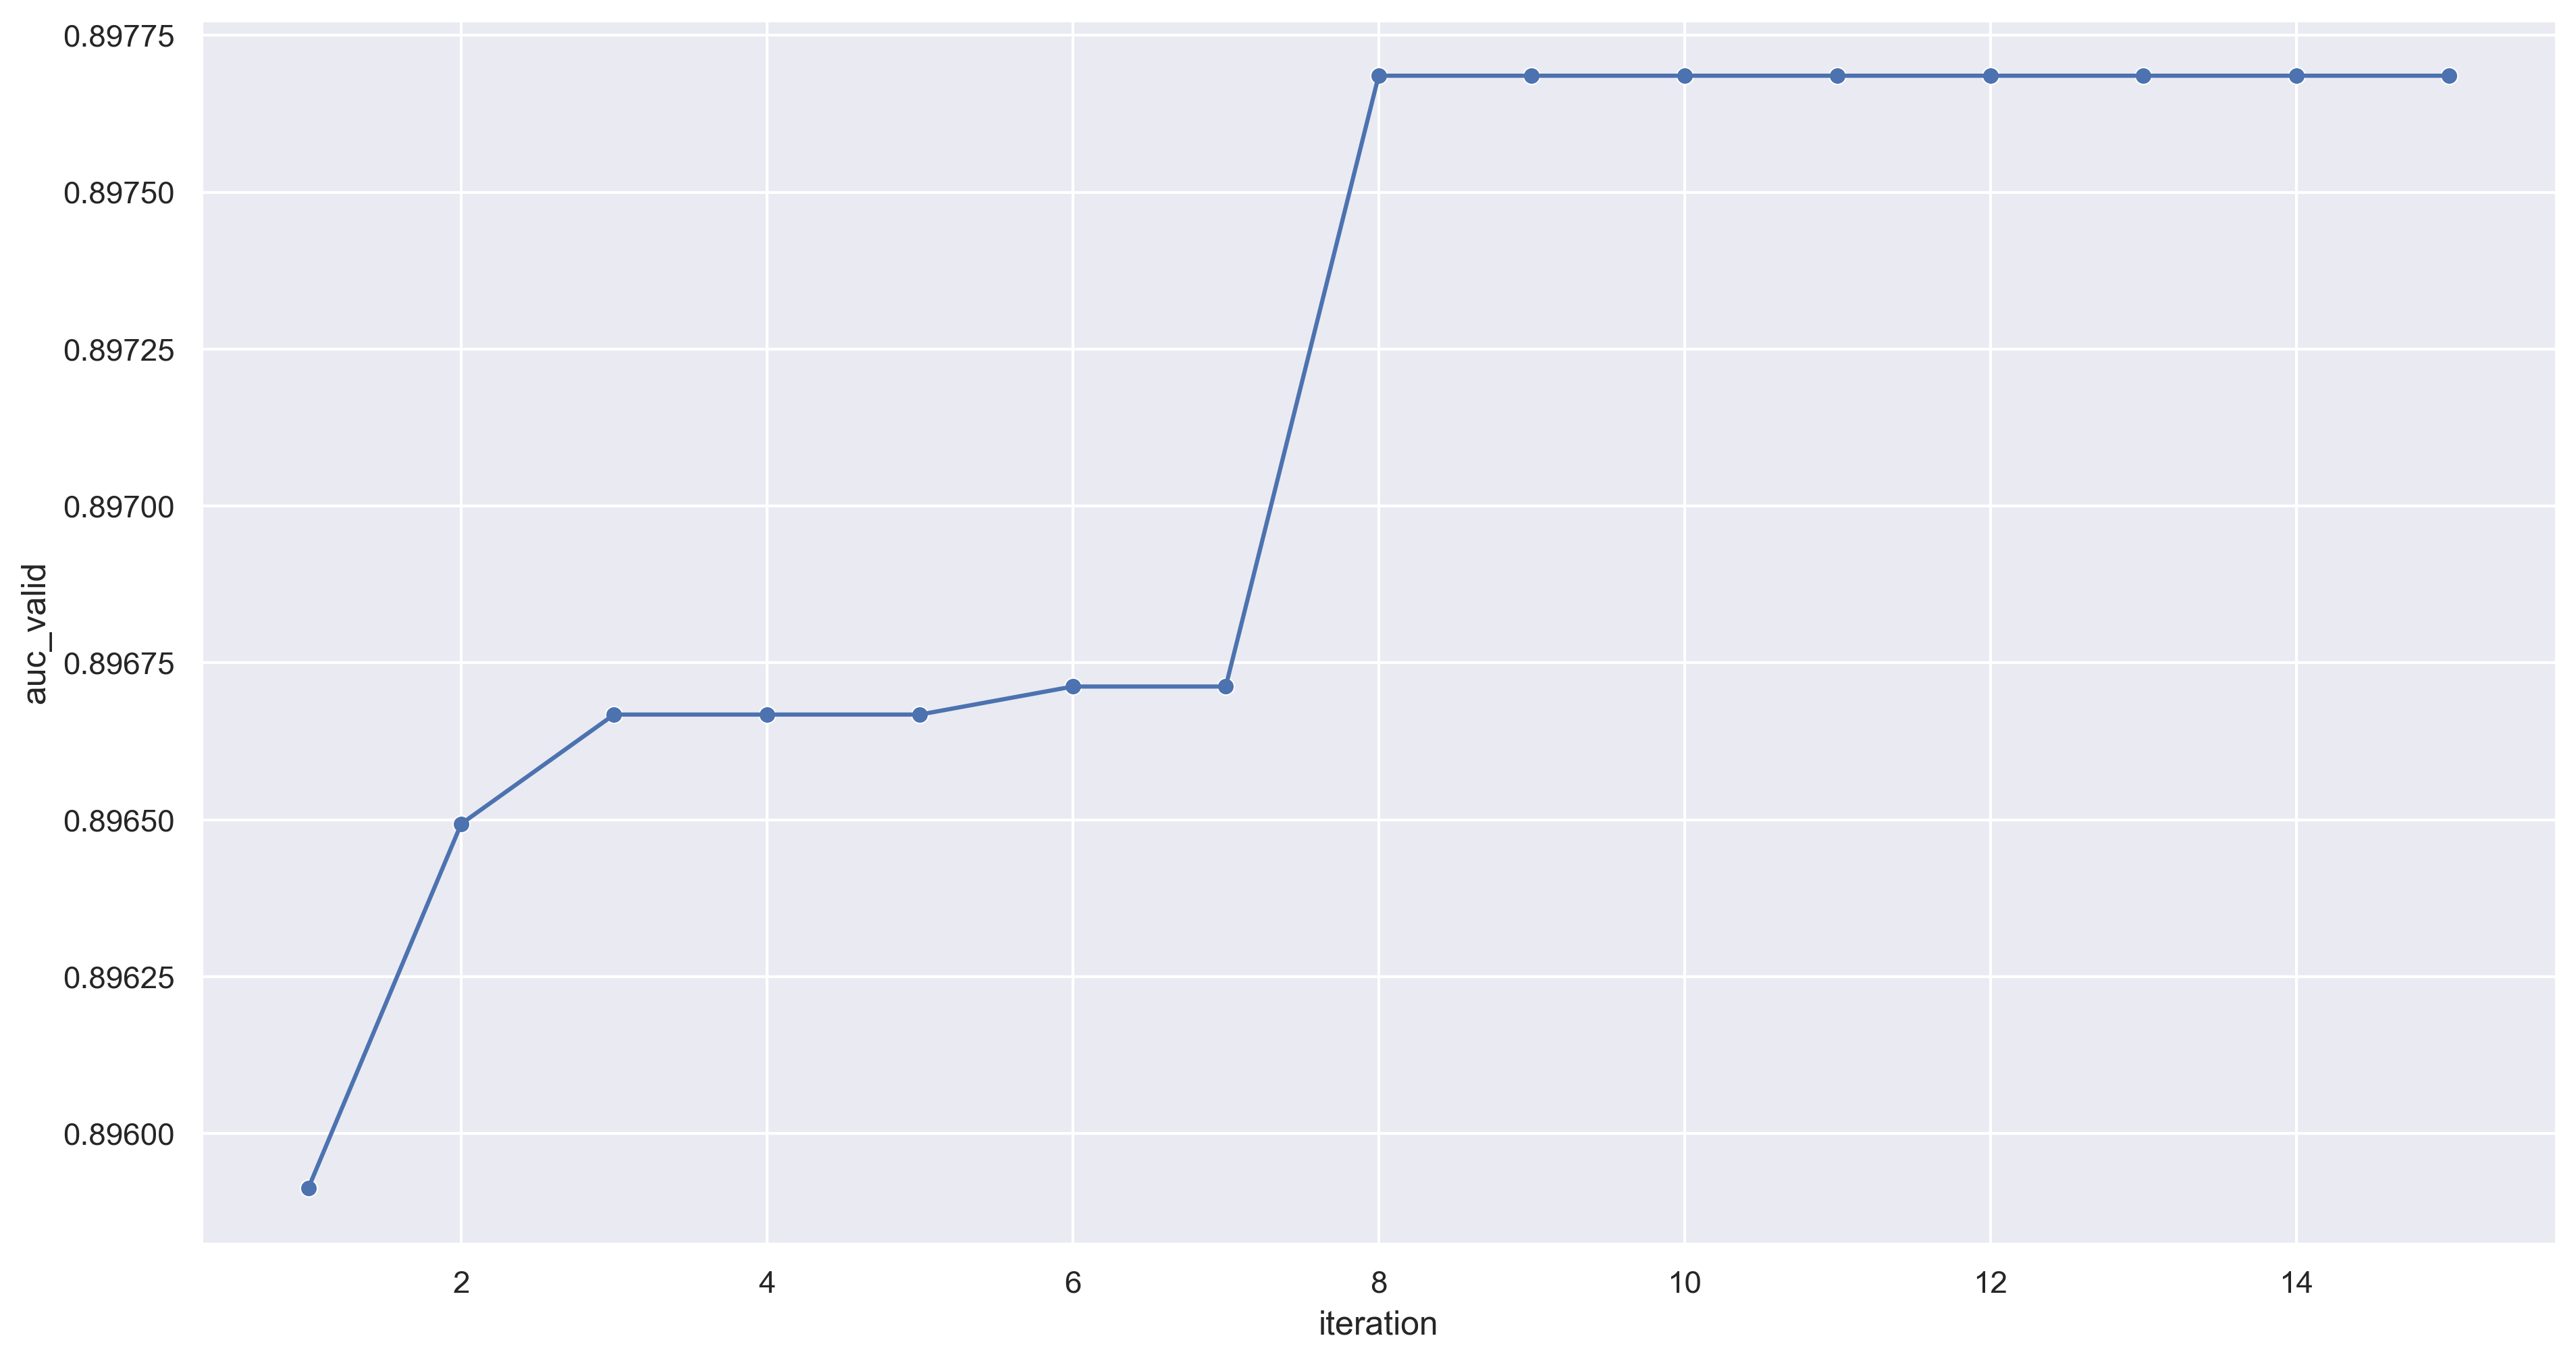

In [31]:
plt.figure(figsize=(15,8),dpi=300) # 分辨率设为300 字体清晰
sns.lineplot(x="iteration", y="auc_valid", data=plot_f_df)
sns.scatterplot(x="iteration", y="auc_valid", data=plot_f_df)
plt.savefig('./output/PSO_plot_f.png')

In [32]:
# 保存数据
PSO_result_df.to_csv('./output/PSO_result_df.csv',index=False)
plot_f_df.to_csv('./output/plot_f_df.csv',index=False)

In [8]:
# 开始读取数据 之前忘了保存最优模型
PSO_result_df = pd.read_csv('./output/PSO_result_df.csv')

In [9]:
PSO_result_df

,param,best_iteration,iteration,i,auc_valid,auc_test,acc_test,precision_test,recall_test,f1_test
0,"{'num_leaves': 348, 'min_data_in_leaf': 29, 'b...",43,1,1,0.891670,0.890164,0.929455,0.692410,0.328490,0.445587
1,"{'num_leaves': 161, 'min_data_in_leaf': 188, '...",77,1,2,0.891764,0.893225,0.930709,0.710243,0.332912,0.453333
2,"{'num_leaves': 125, 'min_data_in_leaf': 33, 'b...",447,1,4,0.893058,0.890009,0.930764,0.749601,0.296905,0.425339
3,"{'num_leaves': 302, 'min_data_in_leaf': 137, '...",45,1,6,0.893360,0.890876,0.930491,0.717514,0.320910,0.443474
4,"{'num_leaves': 60, 'min_data_in_leaf': 58, 'ba...",622,1,9,0.895817,0.896703,0.932018,0.745614,0.322173,0.449934
5,"{'num_leaves': 294, 'min_data_in_leaf': 191, '...",334,1,22,0.895913,0.895760,0.931582,0.737681,0.321541,0.447866
6,"{'num_leaves': 128, 'min_data_in_leaf': 35, 'b...",365,2,4,0.896494,0.892345,0.931091,0.745763,0.305749,0.433692
7,"{'num_leaves': 414, 'min_data_in_leaf': 37, 'b...",546,6,5,0.896712,0.895200,0.930982,0.748044,0.301958,0.430243
8,"{'num_leaves': 252, 'min_data_in_leaf': 36, 'b...",1142,8,29,0.897686,0.895716,0.930927,0.733728,0.313329,0.439132


In [10]:
train_df = train
test_df = test

In [11]:
features = list(train_df)
features.remove('hospital_death')
target = 'hospital_death'

In [21]:
PSO_result_df.iloc[4][0]

"{'num_leaves': 60, 'min_data_in_leaf': 58, 'bagging_fraction': 0.3585196047488155, 'feature_fraction': 0.27410864656673023, 'learning_rate': 0.019685575152797005, 'min_child_weight': 0.0011260761419002604, 'reg_alpha': 0.22164960247292054, 'reg_lambda': 0.7018253049766106, 'max_depth': 26, 'metric': 'auc', 'verbose': -1, 'objective': 'binary', 'boosting_type': 'gbdt', 'random_state': 66, 'n_jobs': 7, 'save_binary': True, 'num_iterations': 20000, 'early_stopping_round': 200}"

In [32]:
param_lgb = {'num_leaves': 60, 'min_data_in_leaf': 58, 'bagging_fraction': 0.3585196047488155, 'feature_fraction': 0.27410864656673023, 'learning_rate': 0.019685575152797005, 'min_child_weight': 0.0011260761419002604, 'reg_alpha': 0.22164960247292054, 'reg_lambda': 0.7018253049766106, 'max_depth': 26, 'metric': 'auc', 'verbose': -1, 'objective': 'binary', 'boosting_type': 'gbdt', 'random_state': 66, 'n_jobs': 7, 'save_binary': True, 'num_iterations': 20000, 'early_stopping_round': 200}



fold 1
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.915083	valid_1's auc: 0.881529
[200]	training's auc: 0.9327	valid_1's auc: 0.88651
[300]	training's auc: 0.947477	valid_1's auc: 0.889338
[400]	training's auc: 0.958791	valid_1's auc: 0.890215
[500]	training's auc: 0.967741	valid_1's auc: 0.890929
[600]	training's auc: 0.974439	valid_1's auc: 0.891196
[700]	training's auc: 0.979953	valid_1's auc: 0.891203
[800]	training's auc: 0.984284	valid_1's auc: 0.891253
[900]	training's auc: 0.987935	valid_1's auc: 0.891525
[1000]	training's auc: 0.990778	valid_1's auc: 0.891599
[1100]	training's auc: 0.992952	valid_1's auc: 0.891392
Early stopping, best iteration is:
[969]	training's auc: 0.989912	valid_1's auc: 0.891698

fold 2
Training until validation scores don't improve for 200 rounds
[100]	training's auc: 0.913642	valid_1's auc: 0.891611
[200]	training's auc: 0.931765	valid_1's auc: 0.895204
[300]	training's auc: 0.946643	valid_1's auc: 0.897077
[

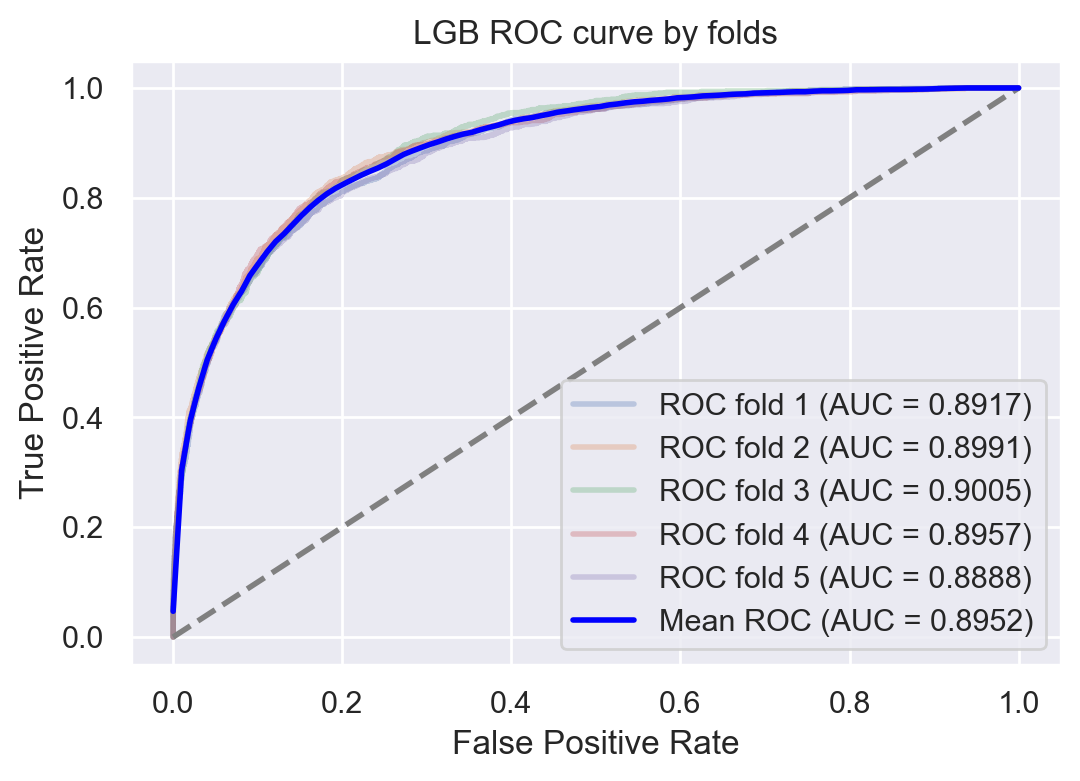

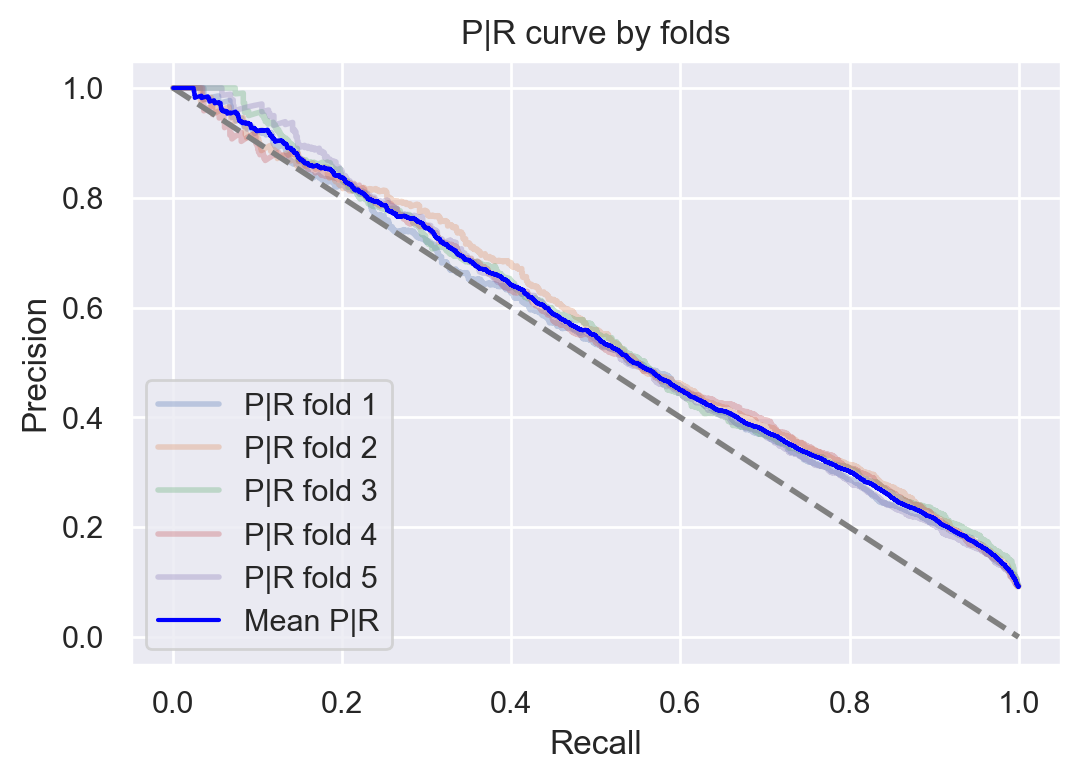

In [33]:
plt.rcParams["axes.grid"] = True
plt.figure(dpi=200)

nfold = 5
skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=42)

oof = np.zeros(len(train_df))
mean_fpr = np.linspace(0,1,100)
cms= []
tprs = []
aucs = []
y_real = []
y_proba = []
recalls = []
roc_aucs = []
f1_scores = []
accuracies = []
precisions = []
predictions = np.zeros(len(test_df))
feature_importance_df = pd.DataFrame()

best_model = None
best_score = 0

i = 1
for train_idx, valid_idx in skf.split(train_df, train_df.hospital_death.values):
    print("\nfold {}".format(i))
    trn_data = lgb.Dataset(train_df.iloc[train_idx][features].values,
                                   label=train_df.iloc[train_idx][target].values
                                   )
    val_data = lgb.Dataset(train_df.iloc[valid_idx][features].values,
                                   label=train_df.iloc[valid_idx][target].values
                                   )   
    
    clf = lgb.train(param_lgb, trn_data, num_boost_round = 500, valid_sets = [trn_data, val_data], verbose_eval = 100, early_stopping_rounds = 100)
    oof[valid_idx] = clf.predict(train_df.iloc[valid_idx][features].values) 
    
    predictions += clf.predict(test_df[features]) / nfold
    
    score = roc_auc_score(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    if (best_score < score):
        best_score = score
        best_model = clf
        
    # Scores 
    roc_aucs.append(score)
    accuracies.append(accuracy_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    recalls.append(recall_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    precisions.append(precision_score(train_df.iloc[valid_idx][target].values ,oof[valid_idx].round()))
    f1_scores.append(f1_score(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Roc curve by folds
    f = plt.figure(1,dpi=200)
    fpr, tpr, t = roc_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    tprs.append(interp(mean_fpr, fpr, tpr))
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, lw=2, alpha=0.3, label='ROC fold %d (AUC = %0.4f)' % (i,roc_auc))
    
    # Precion recall by folds
    g = plt.figure(2,dpi=200)
    precision, recall, _ = precision_recall_curve(train_df.iloc[valid_idx][target].values, oof[valid_idx])
    y_real.append(train_df.iloc[valid_idx][target].values)
    y_proba.append(oof[valid_idx])
    plt.plot(recall, precision, lw=2, alpha=0.3, label='P|R fold %d' % (i))  
    
    i= i+1
    
    # Confusion matrix by folds
    cms.append(confusion_matrix(train_df.iloc[valid_idx][target].values, oof[valid_idx].round()))
    
    # Features imp
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = nfold + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

# Metrics
print(
        '\nCV roc score        : {0:.4f}, std: {1:.4f}.'.format(np.mean(roc_aucs), np.std(roc_aucs)),
        '\nCV accuracy score   : {0:.4f}, std: {1:.4f}.'.format(np.mean(accuracies), np.std(accuracies)),
        '\nCV recall score     : {0:.4f}, std: {1:.4f}.'.format(np.mean(recalls), np.std(recalls)),
        '\nCV precision score  : {0:.4f}, std: {1:.4f}.'.format(np.mean(precisions), np.std(precisions)),
        '\nCV f1 score         : {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_scores), np.std(f1_scores))
)

#ROC 
f = plt.figure(1,dpi=200)
plt.plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'grey')
mean_tpr = np.mean(tprs, axis=0)
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, color='blue',
         label=r'Mean ROC (AUC = %0.4f)' % (np.mean(roc_aucs)),lw=2, alpha=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LGB ROC curve by folds')
plt.legend(loc="lower right")

# PR plt
g = plt.figure(2)
plt.plot([0,1],[1,0],linestyle = '--',lw = 2,color = 'grey')
y_real = np.concatenate(y_real)
y_proba = np.concatenate(y_proba)
precision, recall, _ = precision_recall_curve(y_real, y_proba)
plt.plot(recall, precision, color='blue',
         label=r'Mean P|R')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('P|R curve by folds')
plt.legend(loc="lower left")


plt.show()

In [34]:
y_pred = best_model.predict(test_df)

In [35]:
print("roc score      : {0:.4f}".format(roc_auc_score(test_all['hospital_death'], y_pred)))
print("accuracy score : {0:.4f}".format(accuracy_score(test_all['hospital_death'], y_pred.round())))
print("recall score   : {0:.4f}".format(recall_score(test_all['hospital_death'], y_pred.round())))
print("f1 score       : {0:.4f}".format(f1_score(test_all['hospital_death'], y_pred.round())))
print("precision score: {0:.4f}".format(precision_score(test_all['hospital_death'], y_pred.round())))

roc score      : 0.8953
accuracy score : 0.9309
recall score   : 0.3089
f1 score       : 0.4356
precision score: 0.7387


In [36]:
import joblib
joblib.dump(best_model, "./model/PSO_LGB_best_model.pkl") # 保存模型

['./model/PSO_LGB_best_model.pkl']

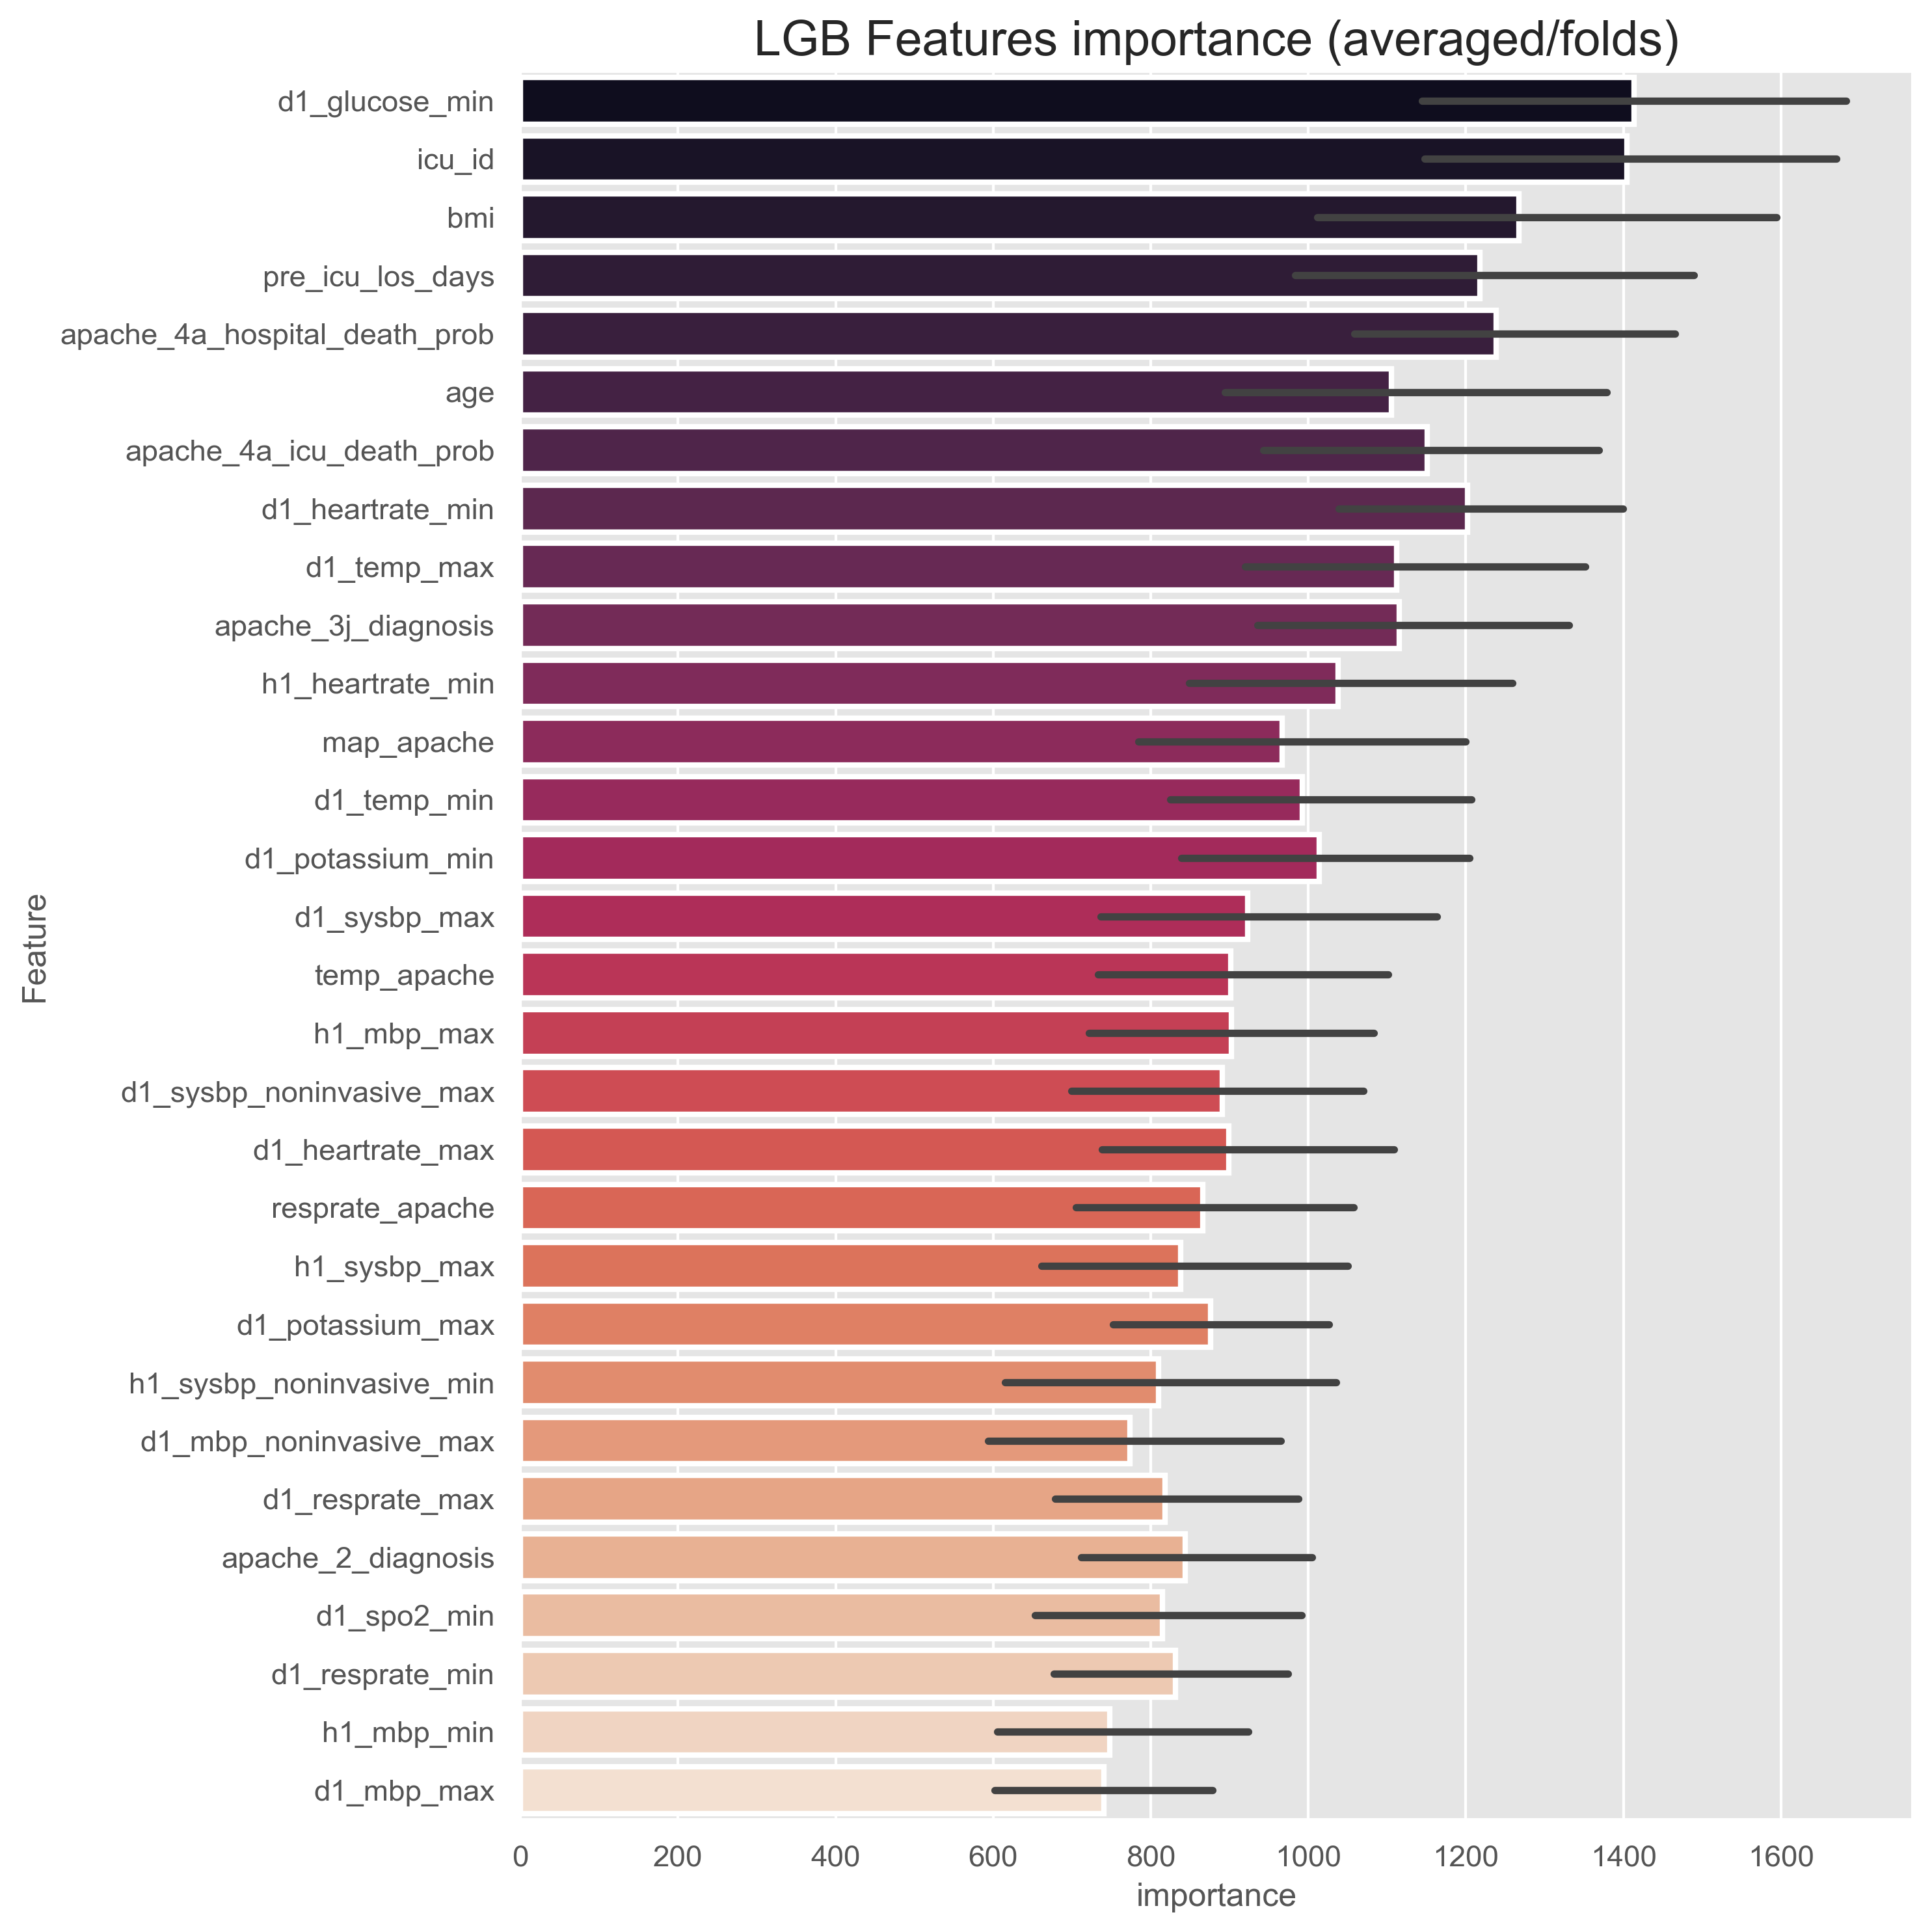

In [38]:
plt.style.use('ggplot')
cols = (feature_importance_df[["Feature", "importance"]]
    .groupby("Feature")
    .mean()
    .sort_values(by="importance", ascending=False)[:30].index)
best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

plt.figure(figsize=(10,10),dpi=300)
sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
        edgecolor=('white'), linewidth=2, palette="rocket")
plt.title('LGB Features importance (averaged/folds)', fontsize=18)
plt.tight_layout()